In [1]:
from tqdm import tqdm
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import umap
import hdbscan 
import seaborn as sns

# UMAP and clustering of isolated C-domain
Here the analysis for the closeness centralities for the C-domain (CD) of FAT10 is shown. They were calculated in [5_Calculating_Closeness_Centralities_Isolated_Domain.ipynb](5_Calculating_Closeness_Centralities_Isolated_Domain.ipynb) for the CD only, ignoring contacts with the rest of the protein. 

## Loading closeness centralities

In [2]:
closeness_CD = np.load("./Closeness_Centralities_C_domain_FAT10_res_88_159.npy")

## Loading the trajectory

In [19]:
topology_file = "./start_frame_FAT10.pdb"
traj_file = "./FAT10_123_traj_center_dt100.xtc"

traj = md.load(traj_file, top = topology_file)

## Calculating the UMAP embedding
To calculate the emebdding, UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) was used in its python implementation with all parameters left at default settings. Please refer to [the documentation](https://umap-learn.readthedocs.io/en/latest/) for more details.

In [3]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(closeness_CD/closeness_CD.max()) # normalizing to have max = 1 in case this was not done upon calculation.

## Plotting UMAP colored by log(density)

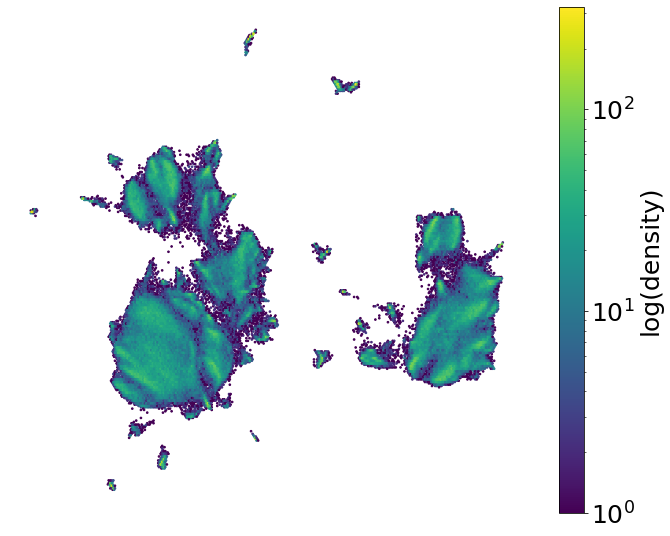

In [4]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
hex_map = ax.hexbin(embedding[:, 0], 
                    embedding[:, 1],
                    cmap = 'viridis', 
                    bins = 'log', 
                    mincnt =1, 
                    gridsize = 300)
ax.set_axis_off()
cb = plt.colorbar(hex_map, 
                  label = "log(density)"
                 )
cb.set_alpha(1)
cb.draw_all()

## Coloring UMAP by closeness centrality of Ile126

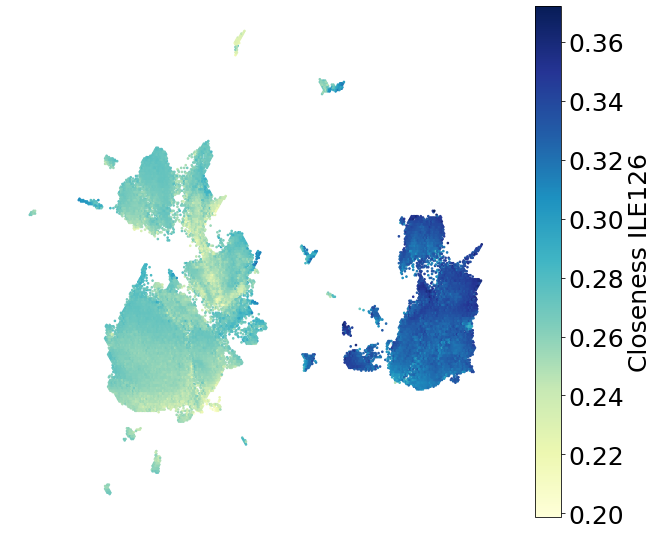

In [5]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
hex_map = ax.hexbin(embedding[:, 0], 
                    embedding[:, 1],
                    cmap = 'YlGnBu', 
                    C = closeness_CD[:,38], #(Residue Ile126 in full length protein)
                    mincnt =1, 
                    gridsize = 300)
ax.set_axis_off()
cb = plt.colorbar(hex_map, 
                  label = "Closeness ILE126"
                 )
cb.set_alpha(1)
cb.draw_all()

## Note: UMAP is non-deterministic.
This means the resulting embeddings can deviate between runs. 
The embeddings may appear rotated or flipped or differ slightly in other details. This can lead to differing results when using HDBSCAN, such as deviations in cluster numbering. To ensure consistency with the analyses in the paper, we provide the [coordinates of the UMAP that was used in the paper](./UMAP_low_d_coordinates_isolated_domain.npy) and proceed in the analyses with those. 

In [13]:
embedding = np.load("./UMAP_low_d_coordinates_isolated_domain.npy")

## HDBSCAN Clustering 
The parameters were selected to divide the UMAP into several large regions to get an overview of the most dominant differences. Based on the density, the clustering could be made in a substantially more fine-grained manner. 

For details on the HDBSCAN parameters, please refer to https://hdbscan.readthedocs.io/en/latest/parameter_selection.html. 

In [14]:
clusterer        = hdbscan.HDBSCAN(min_cluster_size=1500, min_samples=1500)

clusterer.fit(embedding)
cluster_ids           = clusterer.labels_

### Custom color map

In [15]:
color_list = [matplotlib.colors.hex2color(hexcolor) for hexcolor in [   
    "#A9A9A9",      # Neutral Grey (entry 1)
    "#E6E1C5",      # Light Grey-Yellow (muted darkgoldenrod)
    "#D3DADD",      # Light Grey-Blue (muted steelblue)
    "#B0C4DE",      # Light Steelblue
    "#D2B48C",      # Tan (muted brown-gold)
    "#BDB76B",      # Dark Khaki (muted gold-brown)
    "#8FBC8F",      # Dark seagreen
    "#4682B4",      # Steelblue (entry 8)
    "#ADD8E6",      # Light Blue
    "#EEE8AA",      # Pale Goldenrod
    "#B8860B",      # Darkgoldenrod (entry 11)  
]]
color_map = matplotlib.colors.LinearSegmentedColormap.from_list("custom_colormap", color_list)

## Coloring the UMAP based on cluster IDs
gray indicates cluster_id = -1, i.e. HDBSCAN classifies these points as noise. 

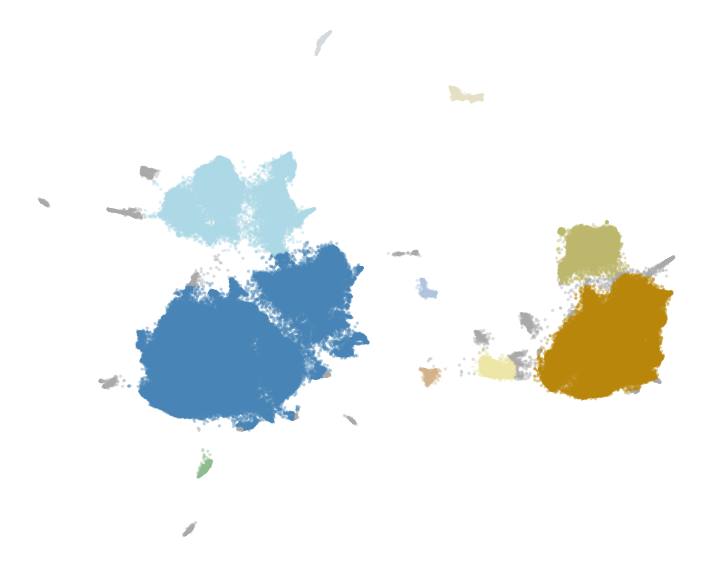

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
ax.scatter(embedding[:, 0], embedding[:, 1],
           s=10, 
           marker="o", 
           linewidths=0, 
           alpha = 0.4,
           c = cluster_ids, 
           cmap = color_map)
ax.set_axis_off()

## Defining the residues which belong to the C-domain for writing out exemplar structures

In [21]:
CD_start_res = 87 # Starting residue of the C-Domain (0-Indexed. This is residue LEU88 in the structure)
CD_end_res = 158 # End residue of the C-Domain (0-Indexed. This is ALA159 in the structure).

## Plotting and writing out cluster exemplar structures based on HDBSCAN `clusterer.exemplars_` 

This serves the purpose of obtaining several structures that are characteristic for a cluster. The cluster exemplars are colored in red in the plot. 
It is evident that the exemplars are not sampled from just a single location in the cluster, but several different regions, which HDBSCAN considers characteristic for the cluster. 
More details on writing out exemplars are explained in [4_Clustering_EncoderMap_full_length_FAT10.ipynb](4_Clustering_EncoderMap_full_length_FAT10.ipynb). 


100%|██████████| 11/11 [00:04<00:00,  2.42it/s]


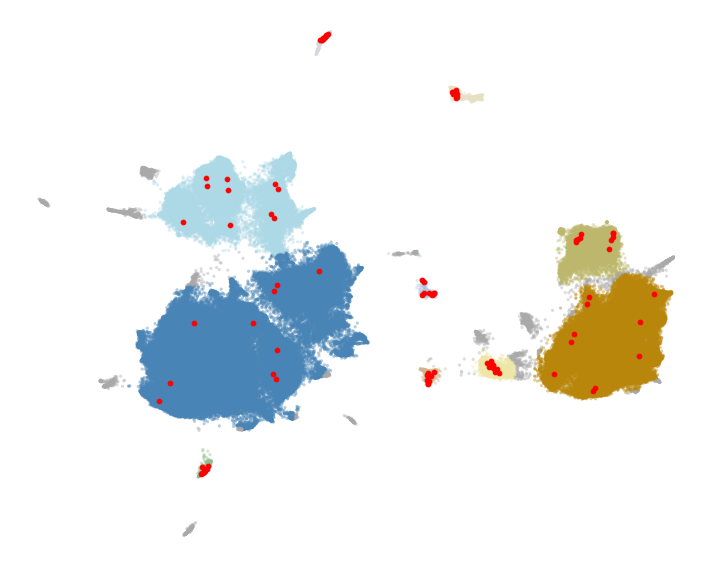

In [23]:
n_representatives = 10
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
ax.scatter(embedding[:, 0], embedding[:, 1],
           s=10, 
           marker="o", 
           linewidths=0, 
           alpha = 0.4,
           c = cluster_ids, 
           cmap = color_map)
ax.set_axis_off()
for cluster in tqdm(np.unique(cluster_ids)): 
    if (cluster > -1): 
        cluster_exemplars_xy = clusterer.exemplars_[cluster]
        if (len(cluster_exemplars_xy) > n_representatives): 
            reduction_factor = int(np.ceil(len(cluster_exemplars_xy)/n_representatives))
            cluster_exemplars_xy = cluster_exemplars_xy[::reduction_factor]
        cluster_exemplars_id = [np.where((embedding == cluster_exemplars_xy[point]).all(axis = 1))[0][0] for point in range(len(cluster_exemplars_xy))]
        ax.scatter(embedding[cluster_exemplars_id, 0], embedding[cluster_exemplars_id, 1], 
           s = 22, 
           c = "red")
        cluster_structures = traj[cluster_exemplars_id].superpose(reference=traj[cluster_exemplars_id[0]], 
                                                                  atom_indices = traj.topology.select(f"resid {CD_start_res} to {CD_end_res}"))
        cluster_structures.save_pdb("./Cluster_Exemplars_UMAP_isolated_domain/UMAP_CD_Cluster_Exemplars_Cluster{}.pdb".format(cluster))